In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

import string

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import top_k_accuracy_score
from textblob import TextBlob 
from textblob import Word

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from langdetect import detect
from deep_translator import GoogleTranslator  

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

2023-06-20 13:03:17.398634: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 13:03:17.589016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 13:03:17.590811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 13:03:20.939871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

[nltk_data] Downloading package punkt to /home/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chris/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/chris/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/chris/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 3)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0., 1.0)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [4]:
X_train = pd.read_csv("../../raw_data/titles_train.csv")["translated_title"].astype(str)
y_train = pd.read_csv("../../raw_data/train_y.csv", delimiter=" ", index_col="Id")['Genre_id']
X_test = pd.read_csv("../../raw_data/titles_test.csv")["translated_title"].astype(str)
y_test = pd.read_csv("../../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [5]:
X_train.head(10)

0    Colet example, and SA sported ronals Gentl Twi...
1               Maghets Pulling Together Pushing Apart
2    ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...
3    AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...
4         City of Rocks Idaho A Climber's Guide untale
5    HOW TO BEAT INSOMNIA MARIANO CHOLIZ MONTANES T...
6    JOHN MARTIN LITTLEJOHN by John Den AN ENIGMA O...
7                   CH EMISTRY De Molar ata Silberberg
8    Mosby's ONCOLOGY NURSING ADVISOR A Comprehensi...
9          IRELAND'S WILD ATLANTIC WAY Carsten Krieger
Name: translated_title, dtype: object

In [6]:
def preprocessed_title(titles):
    output = titles.str.lower()
    output = output.apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    output = output.apply(lambda x: "".join([i for i in x if i not in string.digits]))
    output = output.apply(lambda x: re.split('\W+', x))
    #output = output.apply(lambda x: [str(TextBlob(word).correct()) for word in x])
    porter_stemmer = PorterStemmer()
    output = output.apply(lambda x: [porter_stemmer.stem(word) for word in x])
    stops = set(stopwords.words('english'))
    output = output.apply(lambda x: [word for word in x if word not in stops])
    output = output.apply(lambda x: [word for word in x if len(word) > 2])

    return output

In [7]:
X_train_preproc = preprocessed_title(X_train)
X_test_preproc= preprocessed_title(X_test)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_preproc)

X_train_token = tokenizer.texts_to_sequences(X_train_preproc)
X_test_token = tokenizer.texts_to_sequences(X_test_preproc)

In [9]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', value=0, maxlen=60)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', value=0, maxlen=60)
X_train_pad.shape

(51300, 60)

In [10]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)
y_train_cat.shape

(51300, 30)

In [11]:
vocab_size = len(tokenizer.word_counts)
vocab_size

90148

In [12]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=200,
        input_length=60,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(100, kernel_size=3))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(100, activation="relu", kernel_regularizer="l2"))
    model.add(layers.Dropout(0.30))

    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [13]:
model_cnn = initialize_model()

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat,
              epochs=1000,
              batch_size=16,
              validation_split=0.1,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

2023-06-20 13:03:49.509382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 13:03:49.510165: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-20 13:03:49.617162: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72119200 exceeds 10% of free system memory.
2023-06-20 13:03:49.685170: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72119200 exceeds 10% of free system memory.
2023-06-20 13:03:49.807257: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocatio

Epoch 1/1000


2023-06-20 13:03:50.352591: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72119200 exceeds 10% of free system memory.
2023-06-20 13:03:51.196774: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72119200 exceeds 10% of free system memory.


2886/2886 [==============================] - 190s 65ms/step - loss: 3.0985 - accuracy: 0.1241 - val_loss: 2.9130 - val_accuracy: 0.1561
Epoch 2/1000
2886/2886 [==============================] - 130s 45ms/step - loss: 2.6112 - accuracy: 0.2709 - val_loss: 2.5928 - val_accuracy: 0.2667
Epoch 3/1000
2886/2886 [==============================] - 135s 47ms/step - loss: 2.3173 - accuracy: 0.3821 - val_loss: 2.5322 - val_accuracy: 0.3084
Epoch 4/1000
2886/2886 [==============================] - 143s 50ms/step - loss: 2.1042 - accuracy: 0.4579 - val_loss: 2.6428 - val_accuracy: 0.3224
Epoch 5/1000
2886/2886 [==============================] - 131s 46ms/step - loss: 1.9162 - accuracy: 0.5204 - val_loss: 2.8114 - val_accuracy: 0.3423
Epoch 6/1000
2886/2886 [==============================] - 131s 46ms/step - loss: 1.7296 - accuracy: 0.5813 - val_loss: 2.9315 - val_accuracy: 0.3774
Epoch 7/1000
2886/2886 [==============================] - 131s 45ms/step - loss: 1.5475 - accuracy: 0.6349 - val_loss: 

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

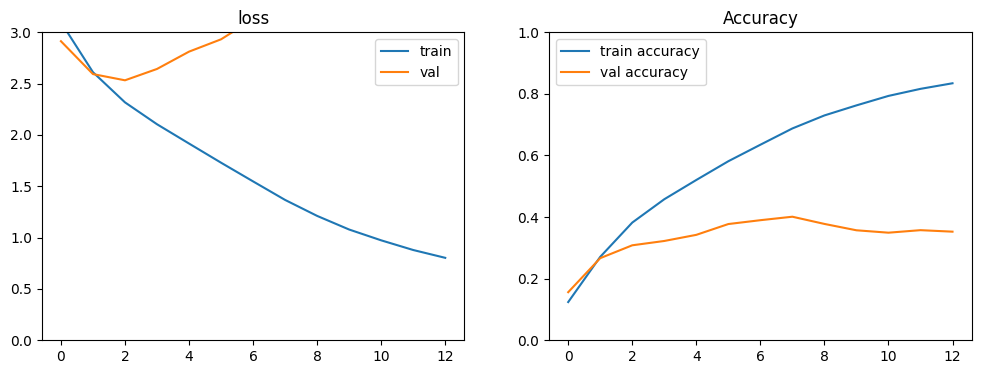

In [14]:
plot_history(history)

In [17]:
y_pred_full = model_cnn.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 4ms/step


In [18]:
top_k_accuracy = top_k_accuracy_score(y_test, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 58.33%


In [ ]:
text = X_train[0]

In [ ]:
nltk_results = ne_chunk(pos_tag(word_tokenize(text)))
for nltk_result in nltk_results:

    if isinstance(nltk_result, nltk.Tree):
        name = ''
        type(nltk_result)
        for nltk_result_leaf in nltk_result.leaves():
            name += nltk_result_leaf[0] + ' '
        print ('Type: ', nltk_result.label(), 'Name: ', name)

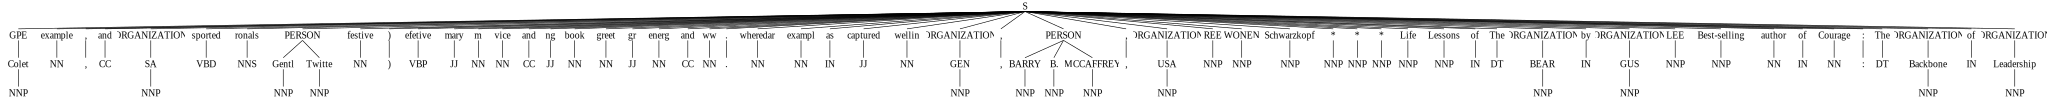

In [143]:
nltk_results

In [52]:
def translate(text):
    try:
        result_lang = detect(text.lower())
        if result_lang != "en":
            translator = GoogleTranslator(source='auto', target='en')
            text = translator.translate(text)
        return text
    except: 
        return text

X_train_translated = X_train.apply(translate)
X_train_translated

0        Colet example, and SA sported ronals Gentl Twi...
1                   Maghets Pulling Together Pushing Apart
2        ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...
3        AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...
4             City of Rocks Idaho A Climber's Guide untale
                               ...                        
51295    JOHN SANDFORD NEW YORK TIMES-BESTSELLING AUTHO...
51296    SECOND EDITION THE CRIME WRITER'S GUIDE TO POL...
51297               THE JEZEBEL REMEDY A Nord MARTIN CLARK
51298                                GLENN OGURA'S STARTUP
51299    Bad karaden The Mystery Mystery Ender KILLER T...
Name: Title, Length: 51300, dtype: object

In [53]:
X_train_full = pd.read_csv("../../raw_data/titles_train.csv")

X_train_full["translated_title"] = X_train_translated

X_train_full.to_csv("../../raw_data/titles_train.csv", header=True, index=False)

In [9]:
X_train_test = X_train[:10]

In [20]:
import logging
import sys
from urllib.parse import quote

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

options = Options()
options.add_argument('--headless')

# logging.basicConfig(level=logging.INFO)
log = logging.getLogger()

def did_you_mean(query, source_language="auto"):
    """
    Spell-checks a sentence.

    :param query: an input sentence to spellcheck.
    :param source_language: a specific language to translate from. Defaults to automated language detection.

    :return: the query after applying suggestions, or unmodified if none is found.
    """

    driver = webdriver.Chrome(options=options)
    query = str(query).strip()
    url = "https://translate.google.com/#view=home&op=translate&sl=%s&tl=en&text=" % source_language + quote(query)

    driver.get(url)
    # log.debug(driver.execute_script("return document.documentElement.outerHTML;"))
    div = driver.find_element(By.ID, "spelling-correction")
    log.info("<div>: [%s]" % div.get_attribute('innerHTML'))
    try:
        a = div.find_element_by_tag_name("a")
        a_html = a.get_attribute('innerHTML')
        log.info("<a>: [%s]" % a_html)
        if len(a_html):
            div = a
    except NoSuchElementException:
        pass
    suggestion = div.text.replace("Did you mean:", "").strip()
    log.info("Suggestion: %s" % suggestion)
    return suggestion if len(suggestion) else query

In [22]:
X_train[0]

'Colet example, and SA sported ronals Gentl Twitte festive) efetive mary m vice and ng book greet gr energ and ww. wheredar exampl as captured wellin GEN, BARRY B. MCCAFFREY, USA REE WONEN Schwarzkopf *** Life Lessons of The BEAR by GUS LEE Best-selling author of Courage: The Backbone of Leadership'

In [23]:
did_you_mean(X_train[1])

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="spelling-correction"]"}
  (Session info: headless chrome=114.0.5735.133); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x56244c37d4e3 <unknown>
#1 0x56244c0acc76 <unknown>
#2 0x56244c0e8c96 <unknown>
#3 0x56244c0e8dc1 <unknown>
#4 0x56244c1227f4 <unknown>
#5 0x56244c10803d <unknown>
#6 0x56244c12030e <unknown>
#7 0x56244c107de3 <unknown>
#8 0x56244c0dd2dd <unknown>
#9 0x56244c0de34e <unknown>
#10 0x56244c33d3e4 <unknown>
#11 0x56244c3413d7 <unknown>
#12 0x56244c34bb20 <unknown>
#13 0x56244c342023 <unknown>
#14 0x56244c3101aa <unknown>
#15 0x56244c3666b8 <unknown>
#16 0x56244c366847 <unknown>
#17 0x56244c376243 <unknown>
#18 0x7f14b17beb43 <unknown>


In [12]:
from selenium import webdriver
import chromedriver_binary

driver = webdriver.Chrome()
driver.get("https://recipes.lewagon.com/recipes/advanced")

In [ ]:
from math import log

# Build a cost dictionary, assuming Zipf's law and cost = -math.log(probability).
words = open("words-by-frequency.txt").read().split()
wordcost = dict((k, log((i+1)*log(len(words)))) for i,k in enumerate(words))
maxword = max(len(x) for x in words)

def infer_spaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return " ".join(reversed(out))

In [47]:
def preprocessed_title_test(titles):
    output = titles.str.lower()
    output = output.apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    output = output.apply(lambda x: "".join([i for i in x if i not in string.digits]))
    output = output.apply(lambda x: re.split('\W+', x))
#     porter_stemmer = PorterStemmer()
#     output = output.apply(lambda x: [porter_stemmer.stem(word) for word in x])
#     stops = set(stopwords.words('english'))
#     output = output.apply(lambda x: [word for word in x if word not in stops])

    return output

In [10]:
from spellchecker import SpellChecker

In [11]:
spell = SpellChecker()

In [21]:
misspelled = spell.unknown(X_train[9].split())
misspelled

{'carsten', "ireland's", 'krieger'}

In [22]:
for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

island's
{'ireland', "roland's", "island's", "leland's"}
trigger
{'ringer', 'rigger', 'trigger', 'wringer', 'briefer', 'bringer'}
cartel
{'fasten', 'caster', 'austen', 'chasten', 'casted', 'cartel', 'larsen', 'carter', 'carted', 'kirsten', 'hasten', 'marten', 'carmen', 'castes', 'carte', 'oarsmen', 'careen', 'carson', 'christen', 'caste', 'carlton', 'carton'}


In [56]:
preproc = preprocessed_title_test(X_train[:10])

In [130]:
def spell_check(text):
    spell = SpellChecker()
    misspelled = spell.unknown(text)

    fixed_words = []
    for word in misspelled:
        candidates = spell.candidates(word)
        if candidates is not None and len(candidates) <= 5:
            correction = spell.correction(word)
            text = [correction if token == word else token for token in text]
            fixed_words.append(word)

    misspelled.difference_update(fixed_words)

    text_copy = text.copy()
    for i, word in enumerate(text_copy[:-1]):
        if word in misspelled and text_copy[i+1] in misspelled:
            combo_word = word + text_copy[i+1]
            candidates = spell.candidates(combo_word)
            if candidates is not None and len(candidates) <= 3:
                text[i] = spell.correction(combo_word)
                text[i+1] = ""

    text = [word for word in text if word != ""]
    return text

In [131]:
spell_check(preproc[0])

['comet',
 'example',
 'and',
 'sa',
 'sported',
 'royals',
 'gentle',
 'twitter',
 'festive',
 'effective',
 'mary',
 'm',
 'vice',
 'and',
 'ng',
 'book',
 'greet',
 'gr',
 'energy',
 'and',
 'ww',
 'wherever',
 'example',
 'as',
 'captured',
 'welling',
 'gen',
 'barry',
 'b',
 'caffrey',
 'usa',
 'ree',
 'women',
 'schwarzkopf',
 'life',
 'lessons',
 'of',
 'the',
 'bear',
 'by',
 'gus',
 'lee',
 'bestselling',
 'author',
 'of',
 'courage',
 'the',
 'backbone',
 'of',
 'leadership']

In [132]:
X_train[0].split()

['Colet',
 'example,',
 'and',
 'SA',
 'sported',
 'ronals',
 'Gentl',
 'Twitte',
 'festive)',
 'efetive',
 'mary',
 'm',
 'vice',
 'and',
 'ng',
 'book',
 'greet',
 'gr',
 'energ',
 'and',
 'ww.',
 'wheredar',
 'exampl',
 'as',
 'captured',
 'wellin',
 'GEN,',
 'BARRY',
 'B.',
 'MCCAFFREY,',
 'USA',
 'REE',
 'WONEN',
 'Schwarzkopf',
 '***',
 'Life',
 'Lessons',
 'of',
 'The',
 'BEAR',
 'by',
 'GUS',
 'LEE',
 'Best-selling',
 'author',
 'of',
 'Courage:',
 'The',
 'Backbone',
 'of',
 'Leadership']